# Klasifikasi Karakter Huruf China dengan Metode CNN

Beberapa contoh klasifikasi dalam kecerdasan buatan ialah pengenalan tulisan tangan. Di dunia ini terdapat beberapa Bahasa yang menggunakan tulisan atau huruf yang tidak memakai alphabet seperti Bahasa China, Jepang, Korea, dan lain-lain.

## Mengimpor Library atau Modul

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

np.random.seed(2)

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.1.0


Perintah di atas merupakan perintah "import" yang digunakan untuk mengimpor beberapa modul yang akan digunakan.

## Memasukkan Dataset

Kemudian setelah memasukkan library, dimasukkan dataset yang digunakan. Dataset yang digunakan ada dua yaitu dataset image dan dataset csv.

In [2]:
data = pd.read_csv('chinese_mnist.csv', low_memory = False)
data.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [3]:
IMAGE_PATH = "C:/Users/Windows 10/Downloads/archive/data/data"
print("dataframe rows:", data.shape[0]) 
print("image files :", len(os.listdir(IMAGE_PATH)))

dataframe rows: 15000
image files : 15000


In [4]:
def file_path_col(data):    
    file_path = f"input_{data[0]}_{data[1]}_{data[2]}.jpg"
    return file_path

data["file_path"] = data.apply(file_path_col, axis = 1)
data.head()

,suite_id,sample_id,code,value,character,file_path
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


In [5]:
data.groupby(["value","character"]).size()

value      character
0          零            1000
1          一            1000
2          二            1000
3          三            1000
4          四            1000
5          五            1000
6          六            1000
7          七            1000
8          八            1000
9          九            1000
10         十            1000
100        百            1000
1000       千            1000
10000      万            1000
100000000  亿            1000
dtype: int64

In [6]:
data.isnull().sum()

suite_id     0
sample_id    0
code         0
value        0
character    0
file_path    0
dtype: int64

## Membagi Data dan Transformasi Data

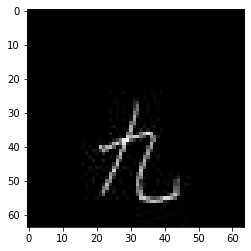

In [7]:
path = os.path.join(IMAGE_PATH, data['file_path'][0])
path_img = imread(path)
plt.imshow(path_img, cmap='gray')

Perintah di bawah digunakan untuk membagi dataset menjadi 2 bagian yaitu Data Train dan data Test. Setelah dibagi, kemudian dibuat bagian lagi yaitu data validasi menggunakan beberapa data pada data train.

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=0, stratify=data["code"].values, shuffle = True)

print(train.shape[0])
print(test.shape[0])

12000
3000


In [9]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=0, stratify=train["code"].values, shuffle = True)

In [10]:
print(f"Train set rows: {train.shape[0]}")
print(f"Test set rows: {test.shape[0]}")
print(f"Val set rows: {val_data.shape[0]}")

Train set rows: 12000
Test set rows: 3000
Val set rows: 2400


Perintah di bawah merupakan perintah untuk mentransformasikan data image menjadi ukuran (64, 64, 1) untuk setiap data train, data validasi dan data test.

In [11]:
import skimage.io
import skimage.transform

def read_image(file_name):
    path = os.path.join(IMAGE_PATH, file_name)
    
    image = skimage.io.imread(path)
    image = skimage.transform.resize(image, (64, 64, 1), mode='reflect')
    
    return image[:,:,:]

def character_encoder(dataset, var='character'):
    X = np.stack(dataset['file_path'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [12]:
X_train, y_train = character_encoder(train)
X_val, y_val = character_encoder(val_data)
X_test, y_test = character_encoder(test)

print(X_train.shape, ",", y_train.shape)
print(X_val.shape, ",", y_val.shape)
print(X_test.shape, ",", y_test.shape)

(12000, 64, 64, 1) , (12000, 15)
(2400, 64, 64, 1) , (2400, 15)
(3000, 64, 64, 1) , (3000, 15)


### Model CNN

In [13]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=X_train.shape[1:], padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(164, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 164)         2

### Melatih Data (Training) dengan Epoch

In [14]:
history = model.fit(X_train, y_train, batch_size=128, epochs=25, validation_data=(X_val, y_val))

Train on 12000 samples, validate on 2400 samples
Epoch 1/25
12000/12000 [==============================] - 99s 8ms/sample - loss: 1.4744 - accuracy: 0.4960 - val_loss: 0.3890 - val_accuracy: 0.8733
Epoch 2/25
12000/12000 [==============================] - 102s 8ms/sample - loss: 0.3168 - accuracy: 0.8886 - val_loss: 0.1586 - val_accuracy: 0.9413
Epoch 3/25
12000/12000 [==============================] - 104s 9ms/sample - loss: 0.1666 - accuracy: 0.9461 - val_loss: 0.0707 - val_accuracy: 0.9800
Epoch 4/25
12000/12000 [==============================] - 101s 8ms/sample - loss: 0.1132 - accuracy: 0.9657 - val_loss: 0.0651 - val_accuracy: 0.9762
Epoch 5/25
12000/12000 [==============================] - 101s 8ms/sample - loss: 0.0624 - accuracy: 0.9799 - val_loss: 0.0253 - val_accuracy: 0.9950
Epoch 6/25
12000/12000 [==============================] - 101s 8ms/sample - loss: 0.0571 - accuracy: 0.9820 - val_loss: 0.0741 - val_accuracy: 0.9750
Epoch 7/25
12000/12000 [============================

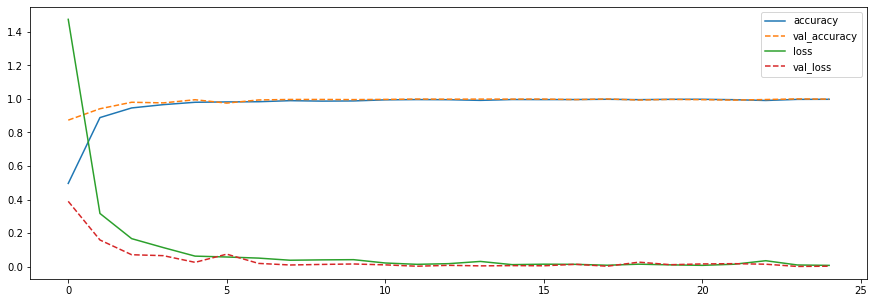

In [15]:
fig, ax = plt.subplots(figsize=(15,5))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy', linestyle='--')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', linestyle='--')
plt.legend()

In [16]:
ModelLoss, ModelAccuracy = model.evaluate(X_test, y_test)

print(f'Test Loss is {ModelLoss}')
print(f'Test Accuracy is {ModelAccuracy}')

3000/3000 [==============================] - 5s 2ms/sample - loss: 0.0235 - accuracy: 0.9940
Test Loss is 0.023504132532466124
Test Accuracy is 0.9940000176429749


### Hasil dan Output

In [17]:
columns_names=y_test.columns
print(list(columns_names))

character_value=data.groupby(["value","character"]).size()
dic_df=dict(character_value)
dic_l=list(dic_df.keys())
dic_v=[i[0] for i in dic_l]
dic_k=[i[1] for i in dic_l]
dic=dict(zip(dic_k, dic_v))
print(dic)

['一', '七', '万', '三', '九', '二', '五', '亿', '八', '六', '十', '千', '四', '百', '零']
{'零': 0, '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9, '十': 10, '百': 100, '千': 1000, '万': 10000, '亿': 100000000}


In [18]:
!pip install pyplotz

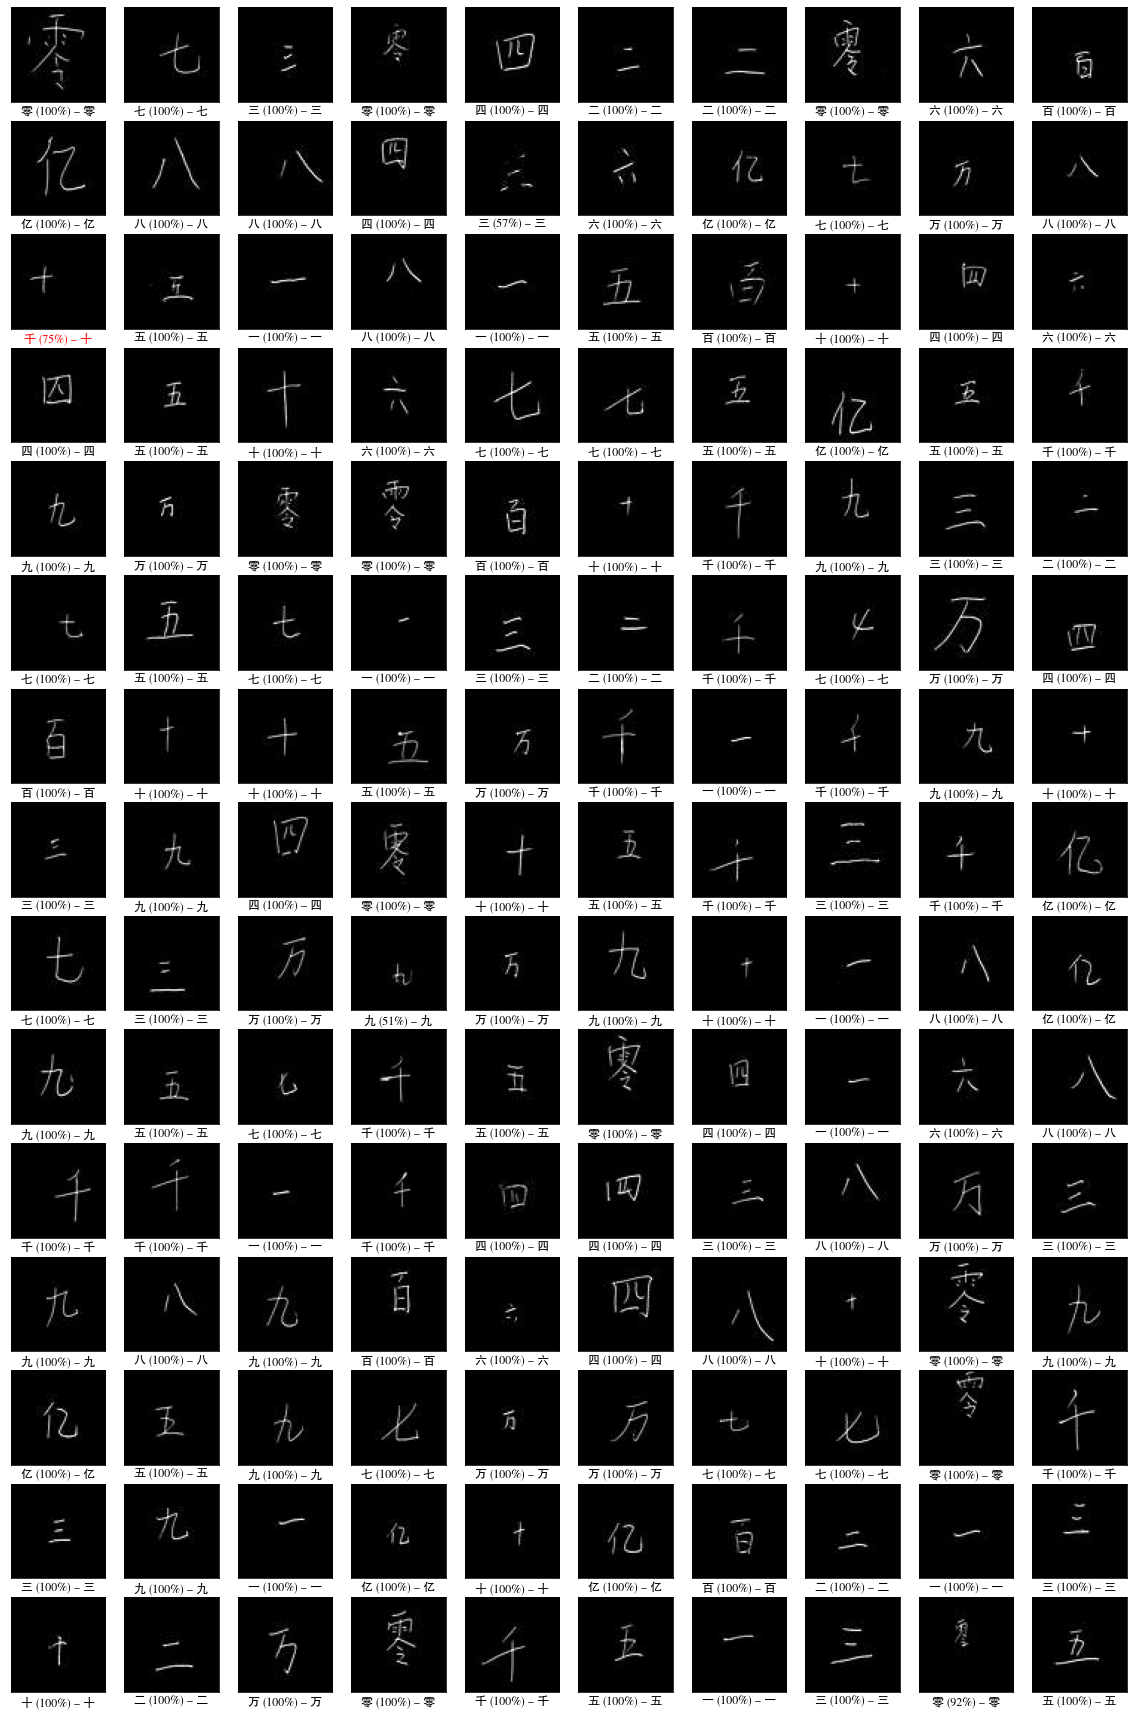

In [19]:
from pyplotz.pyplotz import PyplotZ
pltz = PyplotZ()
pltz.enable_chinese()

predict=model.predict(X_test)

plt.figure(figsize=(20, 31))
for i in range(150):
    
    predicted_label = np.argmax(predict[i])

    row=y_test.iloc[i, :].values.tolist()
    true_label = np.argmax(row)

    columns_names=list(y_test.columns)
    
    color='black'
    if predicted_label!=true_label:
        color='red'
    
    plt.subplot(15, 10, i+1)
    plt.imshow(X_test[i], cmap='gray')
    pltz.xlabel(f"{columns_names[predicted_label]} ({100*predict[i][predicted_label]:2.0f}%) - {columns_names[true_label]}",
                fontsize=12, color=color)
    plt.xticks([])
    plt.yticks([])